In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_score

# Làm sạch dữ liệu

### SmallDS_Raw

In [2]:
matches_small = pd.read_csv("./raw data/SmallDS_raw.csv")

# Loại bỏ những dữ liệu không cần thiết cho việc dự đoán
del matches_small["match report"]
del matches_small["notes"]
del matches_small["attendance"]
del matches_small["referee"]
del matches_small["formation"]
del matches_small["captain"]

In [3]:
matches_small.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,xga,poss,sh,sot,dist,fk,pk,pkatt,season,team
0,2022-05-22,16:00,Premier League,Matchweek 38,Sun,Home,W,3,2,Aston Villa,...,0.2,71.0,24.0,5.0,14.2,1.0,0.0,0.0,2021,Manchester City
1,2022-05-22,16:00,Premier League,Matchweek 38,Sun,Home,W,3,1,Wolves,...,1.3,63.0,29.0,7.0,15.6,0.0,0.0,0.0,2021,Liverpool
2,2022-05-22,16:00,Premier League,Matchweek 38,Sun,Home,W,2,1,Watford,...,0.6,71.0,19.0,8.0,16.9,0.0,0.0,0.0,2021,Chelsea
3,2022-05-22,16:00,Premier League,Matchweek 38,Sun,Away,W,5,0,Norwich City,...,0.5,59.0,19.0,12.0,14.9,0.0,0.0,0.0,2021,Tottenham Hotspur
4,2022-05-22,16:00,Premier League,Matchweek 38,Sun,Home,W,5,1,Everton,...,1.1,73.0,25.0,8.0,17.0,0.0,1.0,1.0,2021,Arsenal


In [4]:
matches_small.shape

(1000, 21)

In [5]:
matches_small.isna().sum()

date        0
time        0
comp        0
round       0
day         0
venue       0
result      0
gf          0
ga          0
opponent    0
xg          0
xga         0
poss        0
sh          0
sot         0
dist        0
fk          0
pk          0
pkatt       0
season      0
team        0
dtype: int64

In [6]:
matches_small['season'].unique()

array([2021, 2020], dtype=int64)

In [7]:
matches_small['ga'].unique()

array([2, 1, 0, 3, 4, 5, 6, 7], dtype=int64)

In [8]:
matches_small['team'].unique()

array(['Manchester City', 'Liverpool', 'Chelsea', 'Tottenham Hotspur',
       'Arsenal', 'Manchester United', 'West Ham United',
       'Leicester City', 'Brighton and Hove Albion',
       'Wolverhampton Wanderers', 'Newcastle United', 'Crystal Palace',
       'Brentford', 'Aston Villa', 'Southampton', 'Everton',
       'Leeds United', 'Burnley', 'Watford', 'Norwich City', 'Fulham',
       'West Bromwich Albion', 'Sheffield United'], dtype=object)

In [9]:
matches_small['opponent'].unique()

array(['Aston Villa', 'Wolves', 'Watford', 'Norwich City', 'Everton',
       'Crystal Palace', 'Brighton', 'Southampton', 'West Ham',
       'Liverpool', 'Burnley', 'Manchester Utd', 'Leeds United',
       'Manchester City', 'Leicester City', 'Arsenal', 'Brentford',
       'Newcastle Utd', 'Chelsea', 'Tottenham', 'West Brom', 'Fulham',
       'Sheffield Utd'], dtype=object)

In [10]:
list_team = np.array(matches_small['team'].unique())
list_opp = np.array(matches_small['opponent'].unique())
result = np.concatenate((list_team, list_opp))
unique_values, counts = np.unique(result, return_counts=True)
result = unique_values[counts == 1]
print(result)

['Brighton' 'Brighton and Hove Albion' 'Manchester United'
 'Manchester Utd' 'Newcastle United' 'Newcastle Utd' 'Sheffield United'
 'Sheffield Utd' 'Tottenham' 'Tottenham Hotspur' 'West Brom'
 'West Bromwich Albion' 'West Ham' 'West Ham United'
 'Wolverhampton Wanderers' 'Wolves']


In [11]:
class MissingDict(dict):
    __missing__ = lambda self, key: key
map_values = {"Brighton and Hove Albion": "Brighton", "Manchester United": "Manchester Utd", "Newcastle United": "Newcastle Utd","Sheffield United": "Sheffield Utd" , "Tottenham Hotspur": "Tottenham", "West Ham United": "West Ham", "Wolverhampton Wanderers": "Wolves"} 
mapping = MissingDict(**map_values)
matches_small["team"] = matches_small["team"].map(mapping)
matches_small["opponent"] = matches_small["opponent"].map(mapping)

In [12]:
matches_small.to_csv('./clean data/SmallDS.csv', index=False)

### BigDS_Raw

In [13]:
matches_big = pd.read_csv("./raw data/BigDS_raw.csv")
del matches_big["match report"]
del matches_big["notes"]
del matches_big["attendance"]
del matches_big["referee"]
del matches_big["formation"]
del matches_big["captain"]

In [14]:
matches_big.shape

(10000, 21)

In [15]:
matches_big.isna().sum()

date           0
time           0
comp           0
round          0
day            0
venue          0
result         0
gf             0
ga             0
opponent       0
xg          1746
xga         1746
poss           2
sh             2
sot            2
dist        1750
fk          2506
pk             2
pkatt          2
season         0
team           0
dtype: int64

In [16]:
matches_big['season'].unique()

array([2021, 2020, 2019, 2018, 2017, 2016], dtype=int64)

In [17]:
matches_big['ga'].unique()

array(['2', '1', '0', '3', '4', '5', '6', '7', '9', '8', '2 (2)', '1 (3)',
       '2.0', '1.0', '3.0', '0.0', '4.0', '5.0', '8.0', '6.0', '7.0',
       '0 (4)'], dtype=object)

In [18]:
matches_big["ga"] = matches_big["ga"].str.replace(".0", "")
matches_big['ga'] = matches_big['ga'].str.split(' ').str[0].astype(int)
matches_big['ga'].unique()

array([2, 1, 0, 3, 4, 5, 6, 7, 9, 8])

In [19]:
matches_big['xg'].unique()

array([3.4, 2.7, 2.2, 4.2, 0.7, 0.2, 1.6, 1.3, 1.8, 0.6, 0.8, 1.1, 0.5,
       0.1, 1.5, 2.4, 2.5, 0.9, 1.4, 1. , 2.1, 2.3, 2. , 0.4, 0.3, 3.1,
       3. , 1.7, 2.6, 1.9, 1.2, 3.6, 2.8, 5.9, 4.6, 2.9, 3.5, 3.2, 4.3,
       3.8, 3.7, 3.3, 4.4, 4. , 4.7, 3.9, 0. , 4.1, 4.5, 4.8, nan, 5.4,
       4.9])

In [20]:
matches_big['gf'].unique()

array(['3', '2', '5', '0', '1', '4', '6', '7', '9', '8', '1 (3)', '2 (2)',
       '1.0', '2.0', '3.0', '0.0', '4.0', '5.0', '8.0', '6.0', '7.0',
       '0 (4)'], dtype=object)

In [21]:
matches_big["gf"] = matches_big["gf"].str.replace(".0", "")
matches_big['gf'] = matches_big['gf'].str.split(' ').str[0].astype(int)
matches_big['gf'].unique()

array([3, 2, 5, 0, 1, 4, 6, 7, 9, 8])

In [22]:
class MissingDict(dict):
    __missing__ = lambda self, key: key
map_values = {"Brighton and Hove Albion": "Brighton", "Manchester United": "Manchester Utd", "Newcastle United": "Newcastle Utd","Sheffield United": "Sheffield Utd" , "Tottenham Hotspur": "Tottenham", "West Ham United": "West Ham", "Wolverhampton Wanderers": "Wolves"} 
mapping = MissingDict(**map_values)
matches_big["team"] = matches_big["team"].map(mapping)
matches_big["opponent"] = matches_big["opponent"].map(mapping)

In [23]:
matches_big.to_csv('./clean data/BigDS.csv', index=False)

# Xử lý dữ liệu trống

### BigDS

In [1]:
matches_big = pd.read_csv("./clean data/BigDS.csv")

NameError: name 'pd' is not defined

In [25]:
matches_big.shape

(10000, 21)

In [26]:
matches_big.isna().sum()

date           0
time           0
comp           0
round          0
day            0
venue          0
result         0
gf             0
ga             0
opponent       0
xg          1746
xga         1746
poss           2
sh             2
sot            2
dist        1750
fk          2506
pk             2
pkatt          2
season         0
team           0
dtype: int64

In [27]:
mean = matches_big.groupby(['team', 'opponent'])[['xg', 'xga', 'dist', 'fk', 'pk', 'pkatt', 'poss', 'sh', 'sot']].transform('mean')
matches_big['xg'].fillna(mean['xg'], inplace=True)
matches_big['xga'].fillna(mean['xga'], inplace=True)
matches_big['dist'].fillna(mean['dist'], inplace=True)
matches_big['fk'].fillna(mean['fk'], inplace=True)
matches_big['pk'].fillna(mean['pk'], inplace=True)
matches_big['pkatt'].fillna(mean['pkatt'], inplace=True)
matches_big['poss'].fillna(mean['poss'], inplace=True)
matches_big['sh'].fillna(mean['sh'], inplace=True)
matches_big['sot'].fillna(mean['sot'], inplace=True)

In [28]:
matches_big.isna().sum()

date          0
time          0
comp          0
round         0
day           0
venue         0
result        0
gf            0
ga            0
opponent      0
xg          412
xga         412
poss          0
sh            0
sot           0
dist        412
fk          628
pk            0
pkatt         0
season        0
team          0
dtype: int64

# BigDS

In [29]:
matches = matches_big

In [30]:
matches.shape

(10000, 21)

In [31]:
matches.dtypes

date         object
time         object
comp         object
round        object
day          object
venue        object
result       object
gf            int64
ga            int64
opponent     object
xg          float64
xga         float64
poss        float64
sh          float64
sot         float64
dist        float64
fk          float64
pk          float64
pkatt       float64
season        int64
team         object
dtype: object

In [32]:
matches["date"] = pd.to_datetime(matches["date"])

In [33]:
# Chuyển đổi dữ liệu về dạng số
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["round_code"] = matches["round"].astype("category").cat.codes
matches["comp_code"] = matches['comp'].apply(lambda x: 1 if x == 'Premier League' else 2)
matches["day"] = matches["date"].dt.dayofweek + 2
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
# thêm cột target là 1 nêu cột result là 'W' và là 0 nếu 'D' hoặc 'L'
matches['target'] = matches['result'].apply(lambda x: 1 if x == 'W' else 0)
# thêm cột goals_dif (số bàn thắng đội nhà trừ số bàn thắng đội đối đầu)
matches['goals_dif'] = matches['gf'] - matches['ga']
matches["point_win"] = matches["result"].astype("category").cat.codes
matches

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,season,team,venue_code,opp_code,round_code,comp_code,hour,target,goals_dif,point_win
0,2022-05-22,16:00,Premier League,Matchweek 38,8,Home,W,3,2,Aston Villa,...,2021,Manchester City,1,1,32,1,16,1,1,2
1,2022-05-22,16:00,Premier League,Matchweek 38,8,Home,W,3,1,Wolves,...,2021,Liverpool,1,51,32,1,16,1,2,2
2,2022-05-22,16:00,Premier League,Matchweek 38,8,Home,W,2,1,Watford,...,2021,Chelsea,1,47,32,1,16,1,1,2
3,2022-05-22,16:00,Premier League,Matchweek 38,8,Away,W,5,0,Norwich City,...,2021,Tottenham,0,33,32,1,16,1,5,2
4,2022-05-22,16:00,Premier League,Matchweek 38,8,Home,W,5,1,Everton,...,2021,Arsenal,1,19,32,1,16,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2017-09-09,15:00,Championship,Matchweek 6,7,Away,W,1,0,Reading,...,2017,Bristol City,0,38,43,2,15,1,1,2
9996,2017-09-09,15:00,Championship,Matchweek 6,7,Away,L,1,2,QPR,...,2017,Ipswich Town,0,37,43,2,15,0,-1,1
9997,2017-09-09,15:00,Championship,Matchweek 6,7,Home,W,5,0,Burton Albion,...,2017,Leeds United,1,12,43,2,15,1,5,2
9998,2017-09-09,15:00,Championship,Matchweek 6,7,Home,W,1,0,Birmingham City,...,2017,Norwich City,1,3,43,2,15,1,1,2


In [34]:
# Thêm cột dữ dữ liệu xếp hạng mùa trước của 1 đội bóng
df = pd.read_csv("./clean data/Ranking.csv")
df

,team,season,comp,rank
0,Manchester City,2021,Premier-League-Stats,1
1,Liverpool,2021,Premier-League-Stats,2
2,Chelsea,2021,Premier-League-Stats,3
3,Tottenham Hotspur,2021,Premier-League-Stats,4
4,Arsenal,2021,Premier-League-Stats,5
...,...,...,...,...
259,Burton Albion,2016,Championship-Stats,20
260,Nottingham Forest,2016,Championship-Stats,21
261,Blackburn Rovers,2016,Championship-Stats,22
262,Wigan Athletic,2016,Championship-Stats,23


In [35]:
# Thêm cột dữ dữ liệu xếp hạng mùa trước của 1 đội bóng
df = pd.read_csv("./clean data/Ranking.csv")
df['comp'] = df['comp'].str.replace("-Stats", "").str.replace("-", " ")
data = df.copy()
data_before = data.copy()
data_after = data.copy()

data_after = data_after.loc[data_after['season'] == 2021]
data_after.rename(columns={'season': 'season_before'}, inplace=True)
data_after.rename(columns={'rank': 'rank_before'}, inplace=True)

data_before['season'] = data_before['season'] - 1
merga = pd.merge(data, data_before, on = ['season', 'team'], how = 'right')
merga['season_before'] = merga['season']
merga.rename(columns={'rank_x': 'rank_before'}, inplace=True)
merga.rename(columns={'rank_y': 'rank'}, inplace=True)
merga.rename(columns={'rank_x': 'rank_before'}, inplace=True)
merga.rename(columns={'comp_y': 'comp'}, inplace=True)
merga = merga.drop('comp_x', axis=1)
merga = merga.drop('season', axis=1)
merga = merga.drop('rank', axis=1)
merga = pd.concat((data_after,merga))
merga = merga.loc[merga['season_before'] > 2015]
merga.head(20)

,team,season_before,comp,rank_before
0,Manchester City,2021,Premier League,1.0
1,Liverpool,2021,Premier League,2.0
2,Chelsea,2021,Premier League,3.0
3,Tottenham Hotspur,2021,Premier League,4.0
4,Arsenal,2021,Premier League,5.0
5,Manchester United,2021,Premier League,6.0
6,West Ham United,2021,Premier League,7.0
7,Leicester City,2021,Premier League,8.0
8,Brighton and Hove Albion,2021,Premier League,9.0
9,Wolverhampton Wanderers,2021,Premier League,10.0


In [36]:
# Dữ liệu NaN này là do không tìm thấy rank của mùa trước ở giải đó do đội bóng xuống hạng hoặc thăng hạng
num_nan_rows = merga.isna().sum(axis=0)
num_nan_rows

team              0
season_before     0
comp              0
rank_before      15
dtype: int64

In [37]:
# Chuyển đổi tên chuẩn của 1 số đội bóng
mapping = MissingDict(**map_values)
merga["team"] = merga["team"].map(mapping)

In [38]:
matches['season_before'] = matches['season'] - 1 
matches = pd.merge(matches, merga[['team','season_before','rank_before','comp']], on=['team', 'season_before','comp'], how='left')
matches[['team','season','season_before','rank_before', 'comp']]

,team,season,season_before,rank_before,comp
0,Manchester City,2021,2020,1.0,Premier League
1,Liverpool,2021,2020,3.0,Premier League
2,Chelsea,2021,2020,4.0,Premier League
3,Tottenham,2021,2020,7.0,Premier League
4,Arsenal,2021,2020,8.0,Premier League
...,...,...,...,...,...
9995,Bristol City,2017,2016,17.0,Championship
9996,Ipswich Town,2017,2016,16.0,Championship
9997,Leeds United,2017,2016,7.0,Championship
9998,Norwich City,2017,2016,8.0,Championship


In [39]:
# Tiếp tục thêm các đặc trưng 
merged = matches.merge(matches, left_on=["date", "team"], right_on=["date", "opponent"])
merged['rank_before_dif'] = merged['rank_before_x'] - merged['rank_before_y']
matches['rank_before_dif'] = merged['rank_before_dif']

In [40]:
matches.isna().sum()

date                  0
time                  0
comp                  0
round                 0
day                   0
venue                 0
result                0
gf                    0
ga                    0
opponent              0
xg                  412
xga                 412
poss                  0
sh                    0
sot                   0
dist                412
fk                  628
pk                    0
pkatt                 0
season                0
team                  0
venue_code            0
opp_code              0
round_code            0
comp_code             0
hour                  0
target                0
goals_dif             0
point_win             0
season_before         0
rank_before        1434
rank_before_dif    3353
dtype: int64

In [41]:
# Dữ liệu trống là do không đủ số vòng đấu
missing_rows = matches[matches.isnull().any(axis=1)]
missing_rows.head(5)[['team','opponent','rank_before_dif','season_before','comp','date']]

,team,opponent,rank_before_dif,season_before,comp,date
3070,Southampton,Swansea City,-3.0,2016,Premier League,2018-05-08
3071,Swansea City,Southampton,3.0,2016,Premier League,2018-05-08
3082,Crystal Palace,Stoke City,5.0,2016,Premier League,2018-05-05
3088,Stoke City,Crystal Palace,-4.0,2016,Premier League,2018-05-05
3098,Liverpool,Stoke City,8.0,2016,Premier League,2018-04-28


In [42]:
# Xử lý ở dữ liệu nhỏ
# Tính toán trung bình đặc trưng của 2 đội bóng và điền vào các vị trí trống
mean_rank_before_dif = round(matches.groupby(['team','opponent'])['rank_before_dif'].transform('mean'))
matches['rank_before_dif'].fillna(mean_rank_before_dif, inplace=True)

In [43]:
mean_rank_before_dif = matches['rank_before_dif'].mean()
matches['rank_before_dif'].fillna(mean_rank_before_dif, inplace=True)

In [44]:
mean_rank_before = round(matches.groupby('team')['rank_before'].transform('mean'))
matches['rank_before'].fillna(mean_rank_before, inplace=True)

In [45]:
matches.isna().sum()

date                 0
time                 0
comp                 0
round                0
day                  0
venue                0
result               0
gf                   0
ga                   0
opponent             0
xg                 412
xga                412
poss                 0
sh                   0
sot                  0
dist               412
fk                 628
pk                   0
pkatt                0
season               0
team                 0
venue_code           0
opp_code             0
round_code           0
comp_code            0
hour                 0
target               0
goals_dif            0
point_win            0
season_before        0
rank_before        276
rank_before_dif      0
dtype: int64

In [46]:
# Dữ liệu trống lvới dữ liệu lớn
missing_rows = matches[matches.isnull().any(axis=1)]
missing_rows.head(5)[['team','opponent','rank_before','season_before','comp','date']]

,team,opponent,rank_before,season_before,comp,date
3070,Southampton,Swansea City,8.0,2016,Premier League,2018-05-08
3071,Swansea City,Southampton,15.0,2016,Premier League,2018-05-08
3082,Crystal Palace,Stoke City,14.0,2016,Premier League,2018-05-05
3088,Stoke City,Crystal Palace,13.0,2016,Premier League,2018-05-05
3098,Liverpool,Stoke City,4.0,2016,Premier League,2018-04-28


In [47]:
# Tính giá trị trung bình của cột rank_before
rank_before_mean = matches['rank_before'].mean()
# Điền các giá trị thiếu (NaN) bằng giá trị trung bình
matches['rank_before'].fillna(rank_before_mean, inplace=True)

In [48]:
matches.isna().sum()

date                 0
time                 0
comp                 0
round                0
day                  0
venue                0
result               0
gf                   0
ga                   0
opponent             0
xg                 412
xga                412
poss                 0
sh                   0
sot                  0
dist               412
fk                 628
pk                   0
pkatt                0
season               0
team                 0
venue_code           0
opp_code             0
round_code           0
comp_code            0
hour                 0
target               0
goals_dif            0
point_win            0
season_before        0
rank_before          0
rank_before_dif      0
dtype: int64

In [49]:
# tính toán trung bình trượt cho một nhóm dữ liệu.
def rolling_averages(group, cols, new_cols):
    # sắp xếp lại dữ liệu theo 'date'
    group = group.sort_values("date")
    # tính trung bình trượt của 3 dữ liệu ngay sau nó
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

matches['point_by_rank_before'] = matches['rank_before'] / matches['comp_code']
cols = ["xg","xga","gf", "ga","goals_dif", "sh", "sot", "dist", "fk", "pk", "pkatt", "point_win"]
new_cols = [f"{c}_rolling" for c in cols]

# Tính toán trung bình trượt lần lượt từng team
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('team')
matches_rolling.index = range(matches_rolling.shape[0])
predictors = ["venue_code", "opp_code", "hour", "day", "rank_before", "rank_before_dif","point_by_rank_before"] + new_cols

In [50]:
predictors

['venue_code',
 'opp_code',
 'hour',
 'day',
 'rank_before',
 'rank_before_dif',
 'point_by_rank_before',
 'xg_rolling',
 'xga_rolling',
 'gf_rolling',
 'ga_rolling',
 'goals_dif_rolling',
 'sh_rolling',
 'sot_rolling',
 'dist_rolling',
 'fk_rolling',
 'pk_rolling',
 'pkatt_rolling',
 'point_win_rolling']

## Quan sát mối tương quan các đặc trưng

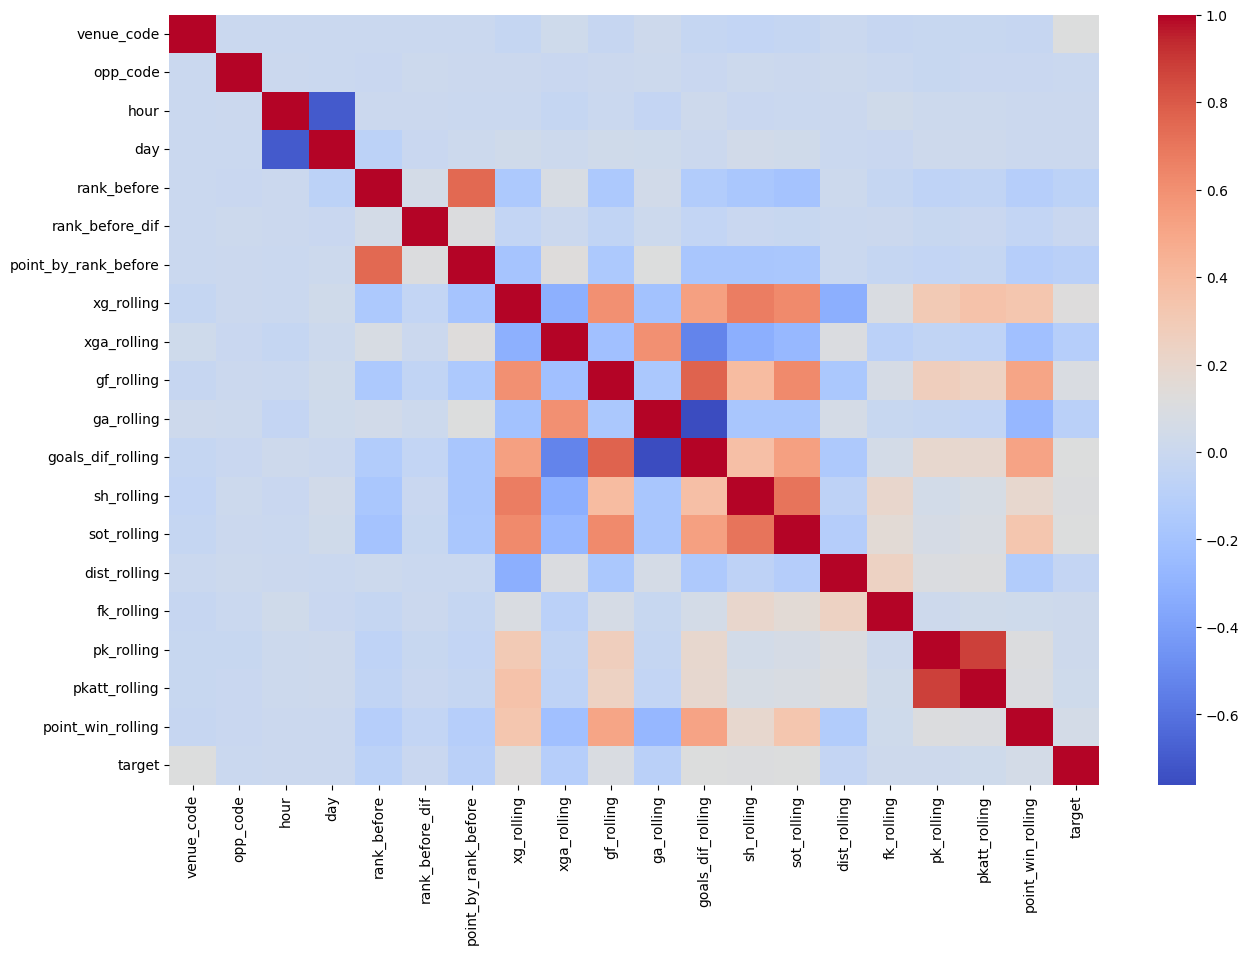

In [51]:
plt.figure(figsize=(15, 10))
sns.heatmap(matches_rolling[predictors+['target']].corr(), cmap='coolwarm')
plt.show()

## Lựa chọn đặc trưng và các siêu tham số với mô hình

In [52]:
def select_best_featurest(X, y, model,k):
    model.fit(X, y)
    feature_importance = model.feature_importances_
    feature_importance = list(zip(X.columns, feature_importance))
    feature_importance = sorted(feature_importance, key=lambda x : x[1], reverse=True)
    feature_importance = feature_importance[:k]
    return feature_importance

In [53]:
def analyze(model, X_train, y_train, X_test, y_test):    
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    preds = model.predict(X_test)
    combined = pd.DataFrame(dict(actual=y_test, predicted=preds), index=X_test.index)
    combined = combined.merge(matches_rolling[["date","season","round", "comp", "team", "opponent",'venue', "result"]], left_index=True, right_index=True)
    return combined

In [54]:
def make_train_test(data,feature_pred): 
    train = data[(data["season"] < 2021)]
    test = data[data["season"] >= 2021]
    # Tách features và target
    X_train = train[feature_pred]
    y_train = train['target']
    X_test = test[feature_pred]
    y_test = test['target']
    return X_train,y_train,X_test,y_test

In [55]:
def found_sample_weith(y_train):
    class_counts = y_train.value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    count_minority = class_counts[minority_class]
    count_majority = class_counts[majority_class]
    weight_majority = count_minority / count_majority
    # weight_majority xấp xỉ 0,6 với size 10000 và 1000
    minority_class = 1
    sample_weights = np.where(y_train == minority_class, minority_class, weight_majority)  
    return sample_weights

In [56]:
def select_predictions_gb(X_train,y_train,X_test,y_test):
    number_feature = list(range(len(predictors), 13, -1))
    my_list = []
    for i in number_feature:
        features = select_best_featurest(X_train,y_train,GradientBoostingClassifier(),i)
        best_features = []
        for feature, _ in features:
            best_features.append(feature)

        X_train = X_train[best_features]
        X_test = X_test[best_features]

        model = GradientBoostingClassifier(random_state = 5)
        params = {
            'learning_rate': [0.1, 0.25 ,0.2],
            'n_estimators' : [100, 125],
            'max_depth': [2, 3],
            'min_samples_leaf': [2, 3, 5],   
            'min_samples_split' : [10, 12, 13],
        }
        model_cv = GridSearchCV(model, params, cv = 2, n_jobs = -1, verbose = False)
        
        # Xử lý mất cân bằng dữ liệu
        sample_weights = found_sample_weith(y_train)
      
        model_cv.fit(X_train,y_train,sample_weight = sample_weights)
        model = model_cv.best_estimator_

        preds = model.predict(X_test)
        accurancy = precision_score(y_test,preds)  
        
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        my_list.append([auc_test, accurancy, model, best_features, i])
    return my_list


def select_predictions_rd(X_train,y_train,X_test,y_test):
    number_feature = list(range(len(predictors), 13, -1))
    my_list = []
    for i in number_feature:
        features = select_best_featurest(X_train,y_train,RandomForestClassifier(),i)
        best_features = []
        for feature, _ in features:
            best_features.append(feature)

        X_train = X_train[best_features]
        X_test = X_test[best_features]

        model = RandomForestClassifier(random_state = 5)
        params = {
                'max_depth':[3, 5],
                'min_samples_split': [5, 10, 15 ],
                'min_samples_leaf': [2, 5, 15],
                'n_estimators' : [100, 150, 200]
                }
        model_cv = GridSearchCV(model, params, cv = 5, n_jobs = -1, verbose = False)
        
        # Xử lý mất cân bằng dữ liệu
        # Tính toán sample_weights dựa trên chênh lệch giữa hai lớp
        sample_weights = found_sample_weith(y_train)
      
        model_cv.fit(X_train,y_train,sample_weight = sample_weights)
        model = model_cv.best_estimator_

        preds = model.predict(X_test)
        accurancy = precision_score(y_test,preds)  
        
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        my_list.append([auc_test, accurancy, model, best_features, i])
    return my_list

In [57]:
matches_rolling.head(10)

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,gf_rolling,ga_rolling,goals_dif_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,point_win_rolling
0,2016-09-10,15:00,Premier League,Matchweek 4,7,Home,W,2,1,Southampton,...,2.000000,1.666667,0.333333,11.000000,5.333333,17.249167,0.263889,0.333333,0.666667,1.000000
1,2016-09-17,15:00,Premier League,Matchweek 5,7,Away,W,4,1,Hull City,...,1.666667,0.666667,1.000000,13.333333,4.333333,16.999167,0.305556,0.666667,0.666667,1.333333
2,2016-12-03,17:30,Premier League,Matchweek 14,7,Away,W,5,1,West Ham,...,1.666667,1.000000,0.666667,12.000000,2.000000,17.982222,0.541667,0.000000,0.000000,0.666667
3,2016-12-10,15:00,Premier League,Matchweek 15,7,Home,W,3,1,Stoke City,...,3.000000,1.000000,2.000000,13.333333,4.666667,17.782222,0.458333,0.000000,0.000000,1.333333
4,2017-01-01,16:00,Premier League,Matchweek 19,8,Home,W,2,0,Crystal Palace,...,1.000000,1.333333,-0.333333,14.000000,5.000000,17.578333,0.291667,0.000000,0.000000,1.333333
5,2017-01-03,19:45,Premier League,Matchweek 20,3,Away,D,3,3,Bournemouth,...,1.333333,0.666667,0.666667,18.333333,6.333333,17.771667,0.458333,0.000000,0.000000,1.666667
6,2017-01-14,15:00,Premier League,Matchweek 21,7,Away,W,4,0,Swansea City,...,2.000000,1.000000,1.000000,20.666667,7.333333,17.587222,0.458333,0.000000,0.000000,1.333333
7,2017-02-11,12:30,Premier League,Matchweek 25,7,Home,W,2,0,Hull City,...,1.333333,2.000000,-0.666667,17.666667,6.000000,17.542500,0.305556,0.333333,0.333333,1.333333
8,2017-04-05,19:45,Premier League,Matchweek 31,4,Home,W,3,0,West Ham,...,1.333333,2.666667,-1.333333,9.000000,2.666667,18.048333,0.291667,0.000000,0.000000,0.666667
9,2017-04-10,20:00,Premier League,Matchweek 32,2,Away,L,0,3,Crystal Palace,...,2.000000,1.666667,0.333333,13.666667,4.333333,18.198333,0.375000,0.000000,0.000000,1.000000


In [58]:
X_train,y_train,X_test,y_test = make_train_test(matches_rolling,predictors)

In [59]:
y_train.value_counts()

target
0    4215
1    2582
Name: count, dtype: int64

In [60]:
y_test.value_counts()

target
0    1160
1     708
Name: count, dtype: int64

### GradientBoostingClassifier

In [61]:
my_list = select_predictions_gb(X_train, y_train, X_test, y_test)
display(pd.DataFrame(my_list, columns=["AUC Score Test","Accuracy Score" ,"Model", "Features","NumFe"]))

,AUC Score Test,Accuracy Score,Model,Features,NumFe
0,0.624139,0.467801,([DecisionTreeRegressor(criterion='friedman_ms...,"[opp_code, rank_before, venue_code, xga_rollin...",19
1,0.616223,0.464239,([DecisionTreeRegressor(criterion='friedman_ms...,"[opp_code, rank_before, venue_code, xga_rollin...",18
2,0.622655,0.477535,([DecisionTreeRegressor(criterion='friedman_ms...,"[opp_code, rank_before, xg_rolling, venue_code...",17
3,0.618083,0.465409,([DecisionTreeRegressor(criterion='friedman_ms...,"[opp_code, rank_before, xg_rolling, xga_rollin...",16
4,0.596468,0.457956,([DecisionTreeRegressor(criterion='friedman_ms...,"[opp_code, rank_before, xga_rolling, venue_cod...",15
5,0.611699,0.463095,([DecisionTreeRegressor(criterion='friedman_ms...,"[opp_code, rank_before, xga_rolling, xg_rollin...",14


In [62]:
# Xem các siêu tham số cho model
list_ = []
for _,_,i,_,_ in my_list:
        print(i)

GradientBoostingClassifier(max_depth=2, min_samples_leaf=2,
                           min_samples_split=10, n_estimators=125,
                           random_state=5)
GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf=5,
                           min_samples_split=13, random_state=5)
GradientBoostingClassifier(min_samples_leaf=3, min_samples_split=13,
                           n_estimators=125, random_state=5)
GradientBoostingClassifier(min_samples_leaf=2, min_samples_split=10,
                           n_estimators=125, random_state=5)
GradientBoostingClassifier(learning_rate=0.25, min_samples_leaf=2,
                           min_samples_split=10, random_state=5)
GradientBoostingClassifier(learning_rate=0.2, max_depth=2, min_samples_leaf=2,
                           min_samples_split=10, n_estimators=125,
                           random_state=5)


In [63]:
# Xem số lượng lựa chọn các thuộc tính
list_ = []
for _,_,_,i,_ in my_list:
    print(i)
    for j in i:
        list_.append(j)
collections.Counter(list_)

['opp_code', 'rank_before', 'venue_code', 'xga_rolling', 'xg_rolling', 'sot_rolling', 'dist_rolling', 'point_win_rolling', 'sh_rolling', 'rank_before_dif', 'point_by_rank_before', 'goals_dif_rolling', 'fk_rolling', 'ga_rolling', 'hour', 'gf_rolling', 'pk_rolling', 'day', 'pkatt_rolling']
['opp_code', 'rank_before', 'venue_code', 'xga_rolling', 'xg_rolling', 'sot_rolling', 'dist_rolling', 'point_win_rolling', 'sh_rolling', 'rank_before_dif', 'point_by_rank_before', 'goals_dif_rolling', 'fk_rolling', 'ga_rolling', 'hour', 'gf_rolling', 'pk_rolling', 'day']
['opp_code', 'rank_before', 'xg_rolling', 'venue_code', 'xga_rolling', 'sot_rolling', 'dist_rolling', 'sh_rolling', 'rank_before_dif', 'point_win_rolling', 'goals_dif_rolling', 'point_by_rank_before', 'fk_rolling', 'ga_rolling', 'gf_rolling', 'hour', 'pk_rolling']
['opp_code', 'rank_before', 'xg_rolling', 'xga_rolling', 'venue_code', 'sot_rolling', 'dist_rolling', 'sh_rolling', 'point_win_rolling', 'rank_before_dif', 'goals_dif_rolling

Counter({'opp_code': 6,
         'rank_before': 6,
         'venue_code': 6,
         'xga_rolling': 6,
         'xg_rolling': 6,
         'sot_rolling': 6,
         'dist_rolling': 6,
         'point_win_rolling': 6,
         'sh_rolling': 6,
         'rank_before_dif': 6,
         'point_by_rank_before': 6,
         'goals_dif_rolling': 6,
         'fk_rolling': 6,
         'hour': 6,
         'ga_rolling': 5,
         'gf_rolling': 4,
         'pk_rolling': 3,
         'day': 2,
         'pkatt_rolling': 1})

In [65]:
best_features = ['opp_code', 'rank_before', 'xg_rolling', 'venue_code', 'xga_rolling', 'sot_rolling', 'dist_rolling', 'sh_rolling', 'rank_before_dif', 'point_win_rolling', 'goals_dif_rolling', 'point_by_rank_before', 'fk_rolling', 'ga_rolling', 'gf_rolling', 'hour', 'pk_rolling']

In [66]:
best_model = GradientBoostingClassifier(min_samples_leaf=3, min_samples_split=13,
                           n_estimators=125, random_state=5)
X_train, y_train, X_test, y_test = make_train_test(matches_rolling, best_features)
sample_weights = found_sample_weith(y_train)
best_model.fit(X_train, y_train, sample_weight = sample_weights)


GradientBoostingClassifier(min_samples_leaf=3, min_samples_split=13,
                           n_estimators=125, random_state=5)

### Đánh giá : GradientBoostingClassifier

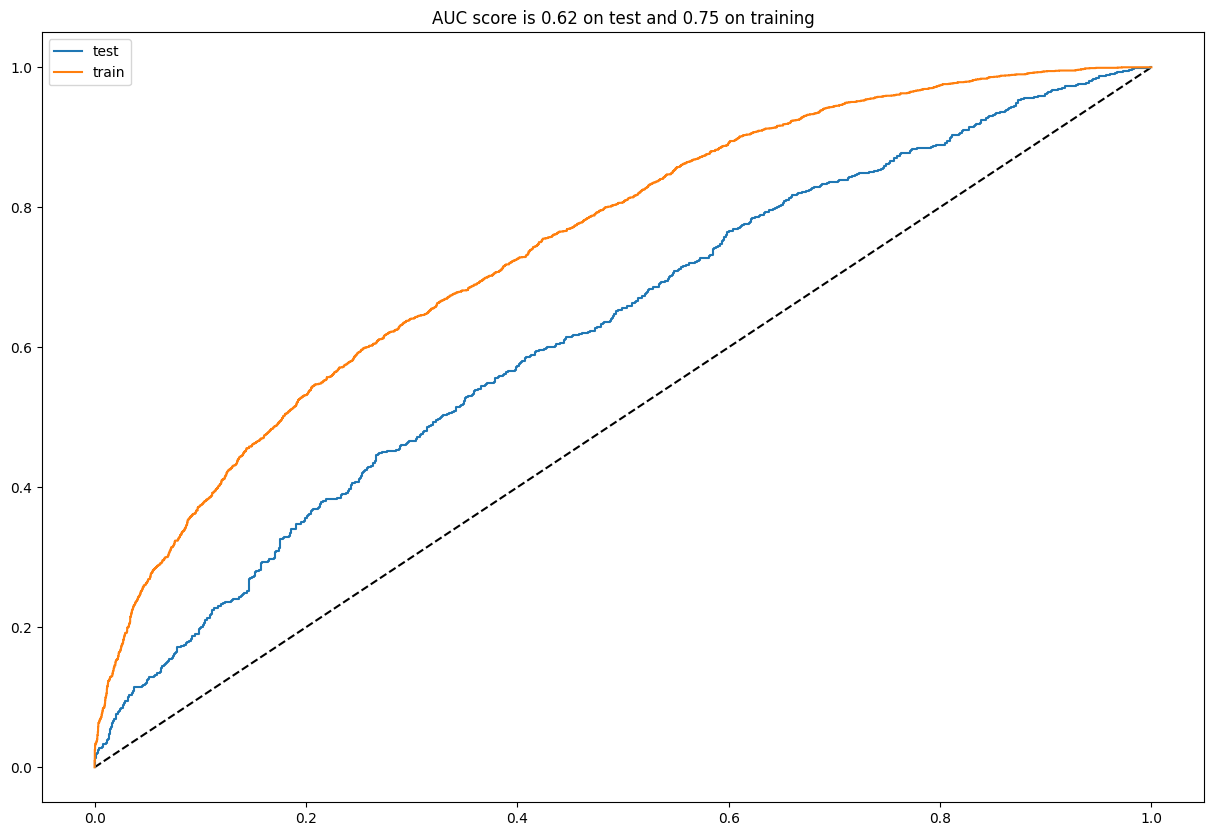

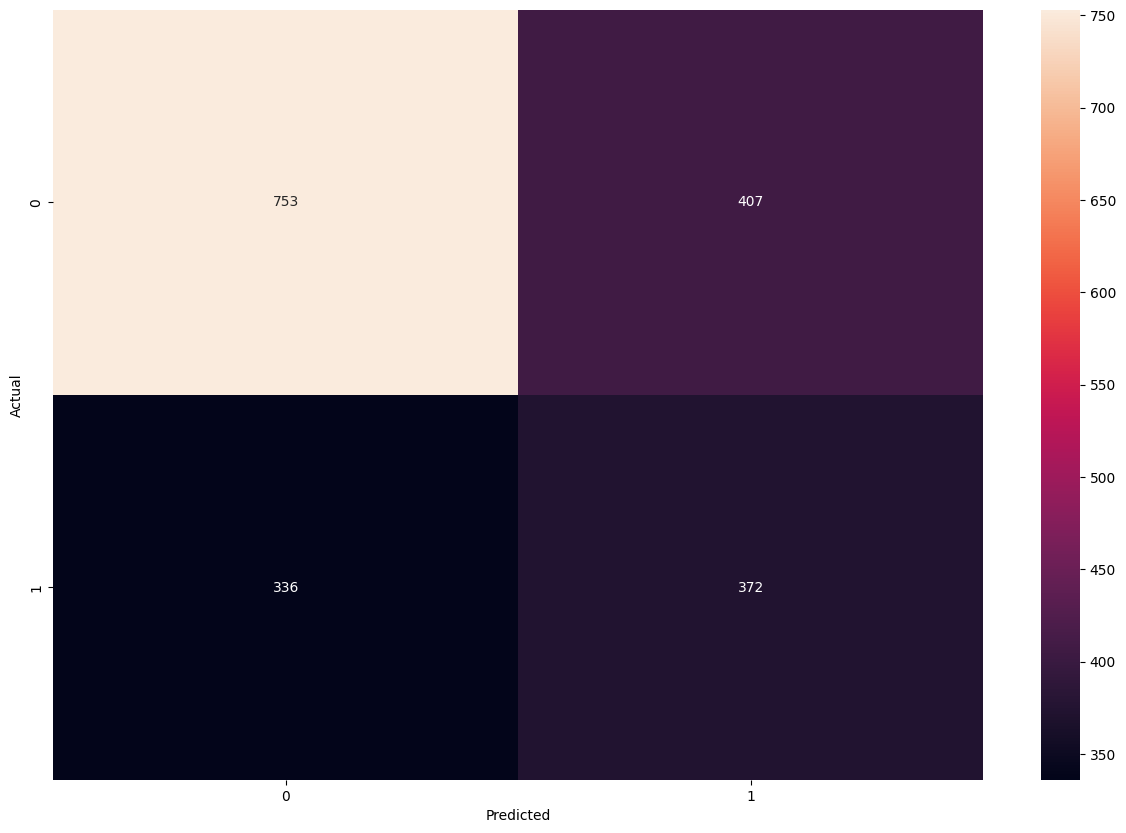

In [70]:
predicted_match = analyze(best_model, X_train[best_features], y_train, X_test[best_features], y_test)

In [72]:
predicted_match.sort_values(["date"], ascending = True).head(20)

,actual,predicted,date,season,round,comp,team,opponent,venue,result
1214,0,0,2021-08-06,2021,Matchweek 1,Championship,Bournemouth,West Brom,Home,D
8145,0,0,2021-08-06,2021,Matchweek 1,Championship,West Bromwich Albion,Bournemouth,Away,D
4455,1,1,2021-08-07,2021,Matchweek 1,Championship,Luton Town,P'borough Utd,Home,W
873,1,1,2021-08-07,2021,Matchweek 1,Championship,Blackburn Rovers,Swansea City,Home,W
1807,0,0,2021-08-07,2021,Matchweek 1,Championship,Bristol City,Blackpool,Home,D
2193,0,0,2021-08-07,2021,Matchweek 1,Championship,Cardiff City,Barnsley,Home,D
2917,0,1,2021-08-07,2021,Matchweek 1,Championship,Derby County,Huddersfield,Home,D
485,0,1,2021-08-07,2021,Matchweek 1,Championship,Barnsley,Cardiff City,Away,D
3507,0,0,2021-08-07,2021,Matchweek 1,Championship,Huddersfield Town,Derby County,Away,D
3675,1,0,2021-08-07,2021,Matchweek 1,Championship,Hull City,Preston,Away,W


In [73]:
merged = predicted_match.merge(predicted_match, left_on=["date", "team"], right_on=["date", "opponent"])
merged.head(30)

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
0,0,0,2021-08-13,2021,Matchweek 1,Premier League,Arsenal,Brentford,Away,L,1,1,2021,Matchweek 1,Premier League,Brentford,Arsenal,Home,W
1,0,1,2021-08-22,2021,Matchweek 2,Premier League,Arsenal,Chelsea,Home,L,1,1,2021,Matchweek 2,Premier League,Chelsea,Arsenal,Away,W
2,0,0,2021-08-28,2021,Matchweek 3,Premier League,Arsenal,Manchester City,Away,L,1,1,2021,Matchweek 3,Premier League,Manchester City,Arsenal,Home,W
3,1,1,2021-09-11,2021,Matchweek 4,Premier League,Arsenal,Norwich City,Home,W,0,0,2021,Matchweek 4,Premier League,Norwich City,Arsenal,Away,L
4,1,0,2021-09-18,2021,Matchweek 5,Premier League,Arsenal,Burnley,Away,W,0,1,2021,Matchweek 5,Premier League,Burnley,Arsenal,Home,L
5,1,1,2021-09-26,2021,Matchweek 6,Premier League,Arsenal,Tottenham,Home,W,0,0,2021,Matchweek 6,Premier League,Tottenham,Arsenal,Away,L
6,0,0,2021-10-02,2021,Matchweek 7,Premier League,Arsenal,Brighton,Away,D,0,0,2021,Matchweek 7,Premier League,Brighton,Arsenal,Home,D
7,0,0,2021-10-18,2021,Matchweek 8,Premier League,Arsenal,Crystal Palace,Home,D,0,0,2021,Matchweek 8,Premier League,Crystal Palace,Arsenal,Away,D
8,1,0,2021-10-22,2021,Matchweek 9,Premier League,Arsenal,Aston Villa,Home,W,0,0,2021,Matchweek 9,Premier League,Aston Villa,Arsenal,Away,L
9,1,0,2021-10-30,2021,Matchweek 10,Premier League,Arsenal,Leicester City,Away,W,0,1,2021,Matchweek 10,Premier League,Leicester City,Arsenal,Home,L


In [74]:
merged[merged['team_x'] == 'Arsenal']

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
0,0,0,2021-08-13,2021,Matchweek 1,Premier League,Arsenal,Brentford,Away,L,1,1,2021,Matchweek 1,Premier League,Brentford,Arsenal,Home,W
1,0,1,2021-08-22,2021,Matchweek 2,Premier League,Arsenal,Chelsea,Home,L,1,1,2021,Matchweek 2,Premier League,Chelsea,Arsenal,Away,W
2,0,0,2021-08-28,2021,Matchweek 3,Premier League,Arsenal,Manchester City,Away,L,1,1,2021,Matchweek 3,Premier League,Manchester City,Arsenal,Home,W
3,1,1,2021-09-11,2021,Matchweek 4,Premier League,Arsenal,Norwich City,Home,W,0,0,2021,Matchweek 4,Premier League,Norwich City,Arsenal,Away,L
4,1,0,2021-09-18,2021,Matchweek 5,Premier League,Arsenal,Burnley,Away,W,0,1,2021,Matchweek 5,Premier League,Burnley,Arsenal,Home,L
5,1,1,2021-09-26,2021,Matchweek 6,Premier League,Arsenal,Tottenham,Home,W,0,0,2021,Matchweek 6,Premier League,Tottenham,Arsenal,Away,L
6,0,0,2021-10-02,2021,Matchweek 7,Premier League,Arsenal,Brighton,Away,D,0,0,2021,Matchweek 7,Premier League,Brighton,Arsenal,Home,D
7,0,0,2021-10-18,2021,Matchweek 8,Premier League,Arsenal,Crystal Palace,Home,D,0,0,2021,Matchweek 8,Premier League,Crystal Palace,Arsenal,Away,D
8,1,0,2021-10-22,2021,Matchweek 9,Premier League,Arsenal,Aston Villa,Home,W,0,0,2021,Matchweek 9,Premier League,Aston Villa,Arsenal,Away,L
9,1,0,2021-10-30,2021,Matchweek 10,Premier League,Arsenal,Leicester City,Away,W,0,1,2021,Matchweek 10,Premier League,Leicester City,Arsenal,Home,L


In [75]:
merged[merged['team_x'] == 'Manchester Utd'].head(20)

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
955,1,1,2021-08-14,2021,Matchweek 1,Premier League,Manchester Utd,Leeds United,Home,W,0,0,2021,Matchweek 1,Premier League,Leeds United,Manchester Utd,Away,L
956,0,1,2021-08-22,2021,Matchweek 2,Premier League,Manchester Utd,Southampton,Away,D,0,0,2021,Matchweek 2,Premier League,Southampton,Manchester Utd,Home,D
957,1,1,2021-08-29,2021,Matchweek 3,Premier League,Manchester Utd,Wolves,Away,W,0,0,2021,Matchweek 3,Premier League,Wolves,Manchester Utd,Home,L
958,1,1,2021-09-11,2021,Matchweek 4,Premier League,Manchester Utd,Newcastle Utd,Home,W,0,0,2021,Matchweek 4,Premier League,Newcastle Utd,Manchester Utd,Away,L
959,1,1,2021-09-19,2021,Matchweek 5,Premier League,Manchester Utd,West Ham,Away,W,0,1,2021,Matchweek 5,Premier League,West Ham,Manchester Utd,Home,L
960,0,1,2021-09-25,2021,Matchweek 6,Premier League,Manchester Utd,Aston Villa,Home,L,1,0,2021,Matchweek 6,Premier League,Aston Villa,Manchester Utd,Away,W
961,0,1,2021-10-02,2021,Matchweek 7,Premier League,Manchester Utd,Everton,Home,D,0,0,2021,Matchweek 7,Premier League,Everton,Manchester Utd,Away,D
962,0,1,2021-10-16,2021,Matchweek 8,Premier League,Manchester Utd,Leicester City,Away,L,1,0,2021,Matchweek 8,Premier League,Leicester City,Manchester Utd,Home,W
963,0,0,2021-10-24,2021,Matchweek 9,Premier League,Manchester Utd,Liverpool,Home,L,1,1,2021,Matchweek 9,Premier League,Liverpool,Manchester Utd,Away,W
964,1,0,2021-10-30,2021,Matchweek 10,Premier League,Manchester Utd,Tottenham,Away,W,0,0,2021,Matchweek 10,Premier League,Tottenham,Manchester Utd,Home,L


In [76]:
count = merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] == 0)]["actual_x"].value_counts()

In [77]:
count = np.array(count)
print(f"1 : {count[0]}")
print(f"0 : {count[1]}")
print((count[0]/(count[0]+count[1]))*100)

1 : 247
0 : 229
51.89075630252101


In [78]:
count = merged[(merged["predicted_x"] == 0) & (merged["predicted_y"] == 1)]["actual_x"].value_counts()

In [79]:
count = np.array(count)
print(f"0 : {count[1]}")
print(f"1 : {count[0]}")
print((count[0]/(count[0]+count[1]))*100)

0 : 110
1 : 361
76.64543524416136


### RandomForestClassifier

In [80]:
X_train,y_train,X_test,y_test = make_train_test(matches_rolling,predictors)

In [81]:
my_list = select_predictions_rd(X_train, y_train, X_test, y_test)
display(pd.DataFrame(my_list, columns=["AUC Score Test","Accuracy Score" ,"Model", "Features","NumFe"]))

,AUC Score Test,Accuracy Score,Model,Features,NumFe
0,0.620891,0.491018,"(DecisionTreeClassifier(max_depth=5, max_featu...","[dist_rolling, xga_rolling, xg_rolling, opp_co...",19
1,0.622973,0.488789,"(DecisionTreeClassifier(max_depth=5, max_featu...","[dist_rolling, xga_rolling, xg_rolling, opp_co...",18
2,0.625509,0.482044,"(DecisionTreeClassifier(max_depth=5, max_featu...","[dist_rolling, xga_rolling, xg_rolling, opp_co...",17
3,0.589718,0.475229,"(DecisionTreeClassifier(max_depth=5, max_featu...","[dist_rolling, xga_rolling, xg_rolling, opp_co...",16
4,0.585506,0.473492,"(DecisionTreeClassifier(max_depth=5, max_featu...","[dist_rolling, xga_rolling, xg_rolling, opp_co...",15
5,0.589407,0.477891,"(DecisionTreeClassifier(max_depth=5, max_featu...","[dist_rolling, xga_rolling, xg_rolling, opp_co...",14


In [ ]:
# Xem các siêu tham số cho model
list_ = []
for _,_,i,_,_ in my_list:
    print(i)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=15,
                       random_state=5)
RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=5)
RandomForestClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=5,
                       n_estimators=200, random_state=5)
RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=200, random_state=5)
RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       random_state=5)
RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=200, random_state=5)


In [82]:
# Xem số lượng lựa chọn các thuộc tính
list_ = []
for _,_,_,i,_ in my_list:
    print(i)
    for j in i:
        list_.append(j)
collections.Counter(list_)

['dist_rolling', 'xga_rolling', 'xg_rolling', 'opp_code', 'sh_rolling', 'rank_before_dif', 'rank_before', 'sot_rolling', 'point_by_rank_before', 'fk_rolling', 'goals_dif_rolling', 'gf_rolling', 'ga_rolling', 'point_win_rolling', 'hour', 'day', 'venue_code', 'pkatt_rolling', 'pk_rolling']
['dist_rolling', 'xga_rolling', 'xg_rolling', 'opp_code', 'rank_before_dif', 'sh_rolling', 'sot_rolling', 'rank_before', 'point_by_rank_before', 'goals_dif_rolling', 'fk_rolling', 'ga_rolling', 'gf_rolling', 'point_win_rolling', 'hour', 'day', 'venue_code', 'pkatt_rolling']
['dist_rolling', 'xga_rolling', 'xg_rolling', 'opp_code', 'sh_rolling', 'rank_before_dif', 'rank_before', 'point_by_rank_before', 'sot_rolling', 'goals_dif_rolling', 'fk_rolling', 'ga_rolling', 'gf_rolling', 'point_win_rolling', 'hour', 'day', 'venue_code']
['dist_rolling', 'xga_rolling', 'xg_rolling', 'opp_code', 'rank_before_dif', 'sh_rolling', 'rank_before', 'point_by_rank_before', 'sot_rolling', 'goals_dif_rolling', 'fk_rolling'

Counter({'dist_rolling': 6,
         'xga_rolling': 6,
         'xg_rolling': 6,
         'opp_code': 6,
         'sh_rolling': 6,
         'rank_before_dif': 6,
         'rank_before': 6,
         'sot_rolling': 6,
         'point_by_rank_before': 6,
         'fk_rolling': 6,
         'goals_dif_rolling': 6,
         'gf_rolling': 6,
         'ga_rolling': 6,
         'hour': 6,
         'point_win_rolling': 5,
         'day': 4,
         'venue_code': 3,
         'pkatt_rolling': 2,
         'pk_rolling': 1})

In [83]:
best_features = ['dist_rolling', 'xga_rolling', 'xg_rolling', 'opp_code', 'sh_rolling', 'rank_before_dif', 'rank_before', 'point_by_rank_before', 'sot_rolling', 'goals_dif_rolling', 'fk_rolling', 'ga_rolling', 'gf_rolling', 'point_win_rolling', 'hour', 'day', 'venue_code']


In [84]:
X_train, y_train, X_test, y_test = make_train_test(matches_rolling, best_features)

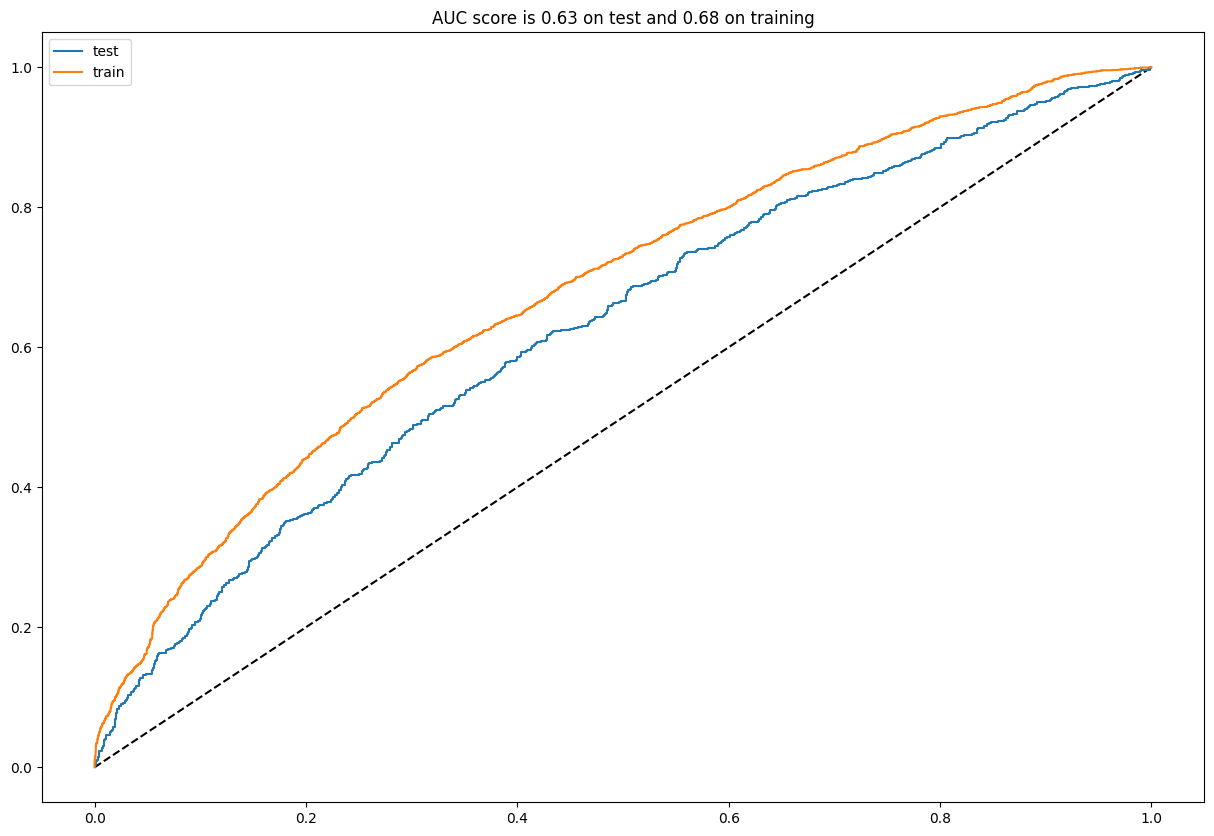

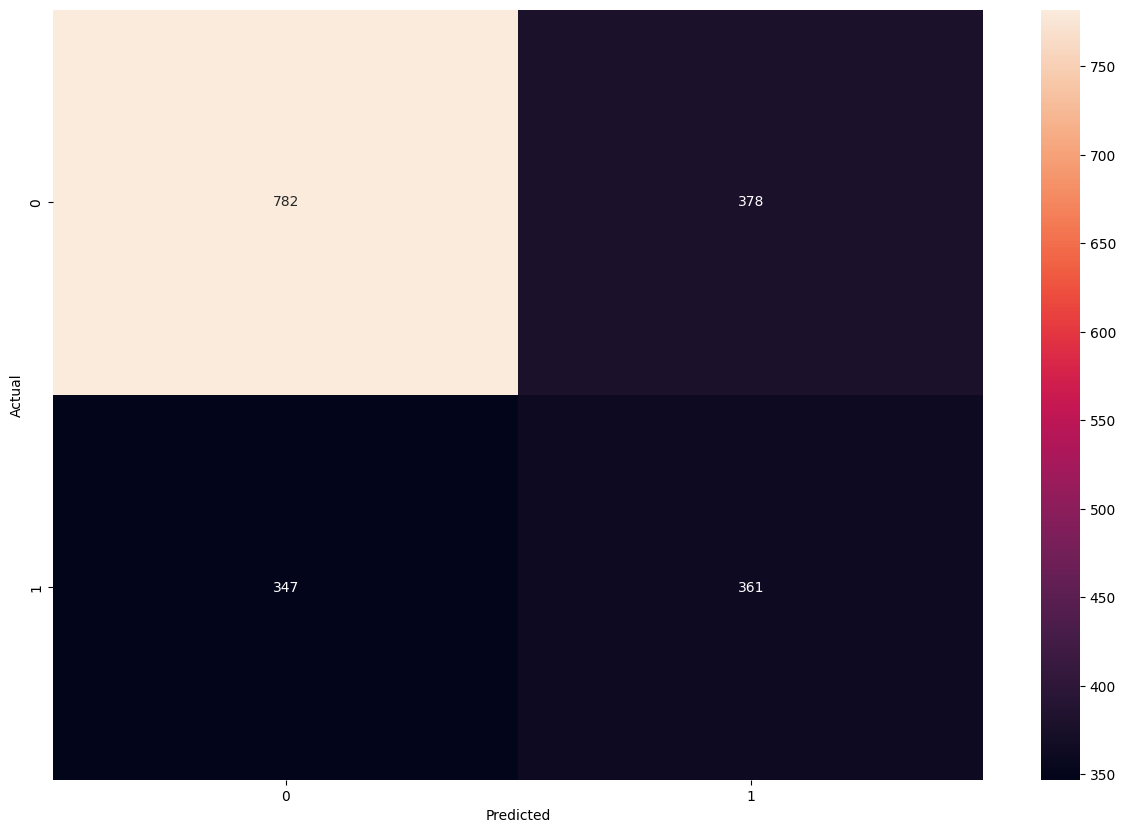

In [85]:
best_model = RandomForestClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=5,
                       n_estimators=200, random_state=5)
sample_weights = found_sample_weith(y_train)
best_model.fit(X_train, y_train, sample_weight = sample_weights)
predicted_match = analyze(best_model, X_train[best_features], y_train, X_test[best_features], y_test)

### Đánh giá : RandomForestClassifier

In [86]:
predicted_match.sort_values(["date"], ascending = True).head(20)
merged = predicted_match.merge(predicted_match, left_on=["date", "team"], right_on=["date", "opponent"])
merged.head(30)

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
0,0,0,2021-08-13,2021,Matchweek 1,Premier League,Arsenal,Brentford,Away,L,1,1,2021,Matchweek 1,Premier League,Brentford,Arsenal,Home,W
1,0,1,2021-08-22,2021,Matchweek 2,Premier League,Arsenal,Chelsea,Home,L,1,1,2021,Matchweek 2,Premier League,Chelsea,Arsenal,Away,W
2,0,0,2021-08-28,2021,Matchweek 3,Premier League,Arsenal,Manchester City,Away,L,1,1,2021,Matchweek 3,Premier League,Manchester City,Arsenal,Home,W
3,1,0,2021-09-11,2021,Matchweek 4,Premier League,Arsenal,Norwich City,Home,W,0,0,2021,Matchweek 4,Premier League,Norwich City,Arsenal,Away,L
4,1,0,2021-09-18,2021,Matchweek 5,Premier League,Arsenal,Burnley,Away,W,0,0,2021,Matchweek 5,Premier League,Burnley,Arsenal,Home,L
5,1,1,2021-09-26,2021,Matchweek 6,Premier League,Arsenal,Tottenham,Home,W,0,0,2021,Matchweek 6,Premier League,Tottenham,Arsenal,Away,L
6,0,0,2021-10-02,2021,Matchweek 7,Premier League,Arsenal,Brighton,Away,D,0,0,2021,Matchweek 7,Premier League,Brighton,Arsenal,Home,D
7,0,0,2021-10-18,2021,Matchweek 8,Premier League,Arsenal,Crystal Palace,Home,D,0,0,2021,Matchweek 8,Premier League,Crystal Palace,Arsenal,Away,D
8,1,1,2021-10-22,2021,Matchweek 9,Premier League,Arsenal,Aston Villa,Home,W,0,0,2021,Matchweek 9,Premier League,Aston Villa,Arsenal,Away,L
9,1,0,2021-10-30,2021,Matchweek 10,Premier League,Arsenal,Leicester City,Away,W,0,1,2021,Matchweek 10,Premier League,Leicester City,Arsenal,Home,L


In [87]:
merged[merged['team_x'] == 'Everton']

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
626,1,0,2021-08-14,2021,Matchweek 1,Premier League,Everton,Southampton,Home,W,0,0,2021,Matchweek 1,Premier League,Southampton,Everton,Away,L
627,0,0,2021-08-21,2021,Matchweek 2,Premier League,Everton,Leeds United,Away,D,0,1,2021,Matchweek 2,Premier League,Leeds United,Everton,Home,D
628,1,0,2021-08-28,2021,Matchweek 3,Premier League,Everton,Brighton,Away,W,0,0,2021,Matchweek 3,Premier League,Brighton,Everton,Home,L
629,1,1,2021-09-13,2021,Matchweek 4,Premier League,Everton,Burnley,Home,W,0,0,2021,Matchweek 4,Premier League,Burnley,Everton,Away,L
630,0,0,2021-09-18,2021,Matchweek 5,Premier League,Everton,Aston Villa,Away,L,1,1,2021,Matchweek 5,Premier League,Aston Villa,Everton,Home,W
631,1,1,2021-09-25,2021,Matchweek 6,Premier League,Everton,Norwich City,Home,W,0,0,2021,Matchweek 6,Premier League,Norwich City,Everton,Away,L
632,0,0,2021-10-02,2021,Matchweek 7,Premier League,Everton,Manchester Utd,Away,D,0,1,2021,Matchweek 7,Premier League,Manchester Utd,Everton,Home,D
633,0,1,2021-10-17,2021,Matchweek 8,Premier League,Everton,West Ham,Home,L,1,1,2021,Matchweek 8,Premier League,West Ham,Everton,Away,W
634,0,0,2021-10-23,2021,Matchweek 9,Premier League,Everton,Watford,Home,L,1,0,2021,Matchweek 9,Premier League,Watford,Everton,Away,W
635,0,0,2021-11-01,2021,Matchweek 10,Premier League,Everton,Wolves,Away,L,1,0,2021,Matchweek 10,Premier League,Wolves,Everton,Home,W


In [88]:
merged[merged['team_x'] == 'Manchester Utd'].head(20)

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
955,1,1,2021-08-14,2021,Matchweek 1,Premier League,Manchester Utd,Leeds United,Home,W,0,0,2021,Matchweek 1,Premier League,Leeds United,Manchester Utd,Away,L
956,0,1,2021-08-22,2021,Matchweek 2,Premier League,Manchester Utd,Southampton,Away,D,0,0,2021,Matchweek 2,Premier League,Southampton,Manchester Utd,Home,D
957,1,1,2021-08-29,2021,Matchweek 3,Premier League,Manchester Utd,Wolves,Away,W,0,1,2021,Matchweek 3,Premier League,Wolves,Manchester Utd,Home,L
958,1,1,2021-09-11,2021,Matchweek 4,Premier League,Manchester Utd,Newcastle Utd,Home,W,0,0,2021,Matchweek 4,Premier League,Newcastle Utd,Manchester Utd,Away,L
959,1,1,2021-09-19,2021,Matchweek 5,Premier League,Manchester Utd,West Ham,Away,W,0,1,2021,Matchweek 5,Premier League,West Ham,Manchester Utd,Home,L
960,0,1,2021-09-25,2021,Matchweek 6,Premier League,Manchester Utd,Aston Villa,Home,L,1,0,2021,Matchweek 6,Premier League,Aston Villa,Manchester Utd,Away,W
961,0,1,2021-10-02,2021,Matchweek 7,Premier League,Manchester Utd,Everton,Home,D,0,0,2021,Matchweek 7,Premier League,Everton,Manchester Utd,Away,D
962,0,1,2021-10-16,2021,Matchweek 8,Premier League,Manchester Utd,Leicester City,Away,L,1,1,2021,Matchweek 8,Premier League,Leicester City,Manchester Utd,Home,W
963,0,1,2021-10-24,2021,Matchweek 9,Premier League,Manchester Utd,Liverpool,Home,L,1,1,2021,Matchweek 9,Premier League,Liverpool,Manchester Utd,Away,W
964,1,0,2021-10-30,2021,Matchweek 10,Premier League,Manchester Utd,Tottenham,Away,W,0,1,2021,Matchweek 10,Premier League,Tottenham,Manchester Utd,Home,L


In [89]:
count = merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] == 0)]["actual_x"].value_counts()
count = np.array(count)
print(f"1 : {count[0]}")
print(f"0 : {count[1]}")
num1 = (count[0]/(count[0]+count[1]))*100
print(num1)

1 : 245
0 : 224
52.23880597014925


In [90]:
count = merged[(merged["predicted_x"] == 0) & (merged["predicted_y"] == 1)]["actual_x"].value_counts()
count = np.array(count)
print(f"0 : {count[1]}")
print(f"1 : {count[0]}")
num2 = (count[0]/(count[0]+count[1]))*100
print(num2)

0 : 112
1 : 357
76.11940298507463


## Tổng kết :